### Import Modules

In [204]:
import torch
import torch.nn as nn

from eojeol_etri_tokenizer.eojeol_tokenization import eojeol_BertTokenizer

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = eojeol_BertTokenizer('./vocab.korean.rawtext.list', do_lower_case=False)
vocab_size = len(tokenizer.vocab)

### Load Data

In [205]:
def load_data(file_root, tokenizer):
    fp = open(file_root, 'r', encoding='utf-8')

    label_list = {
        '[PAD]': 0,
        'B-DT': 1,
        'I-DT': 2,
        'O': 3,
        'B-LC': 4,
        'I-LC': 5,
        'B-OG': 6,
        'I-OG': 7,
        'B-PS': 8,
        'I-PS': 9,
        'B-TI': 10,
        'I-TI': 11,
        'X': 12,
        '[CLS]': 13,
        '[SEP]': 14     
    }

    tokens = []
    ids = []
    labels = []

    max_len = 0
    while True:
        sentence = fp.readline()

        if not sentence:
            break

        sentence_split = sentence.split()

        if len(sentence_split) < 2:
            continue

        eoj = sentence_split[0] 
        tag = sentence_split[1]

        eoj_tk = tokenizer.tokenize(eoj)
        len_tk = len(eoj_tk)
        eoj_tkid = tokenizer.convert_tokens_to_ids(eoj_tk)
        
        label = [label_list['X']]*len_tk
        label[0] = label_list[tag]

        labels.append(label)
        tokens.append(eoj_tk)
        ids.append(eoj_tkid)

        if max_len < len_tk:
            max_len = len_tk

    nb_data = len(labels)
    for i in range(nb_data):
        len_data = len(labels[i])
        if len_data < max_len:
            diff = max_len-len_data
            labels[i] = labels[i] + ([0]*diff)
            tokens[i] = tokens[i] + (['[PAD]']*diff)    
            ids[i] = ids[i] + ([0]*diff)   

    return tokens, ids, labels, nb_data

file_root = './ner_eojeol_label_per_line.txt'
tokens, ids, labels, nb_data = load_data(file_root, tokenizer)    

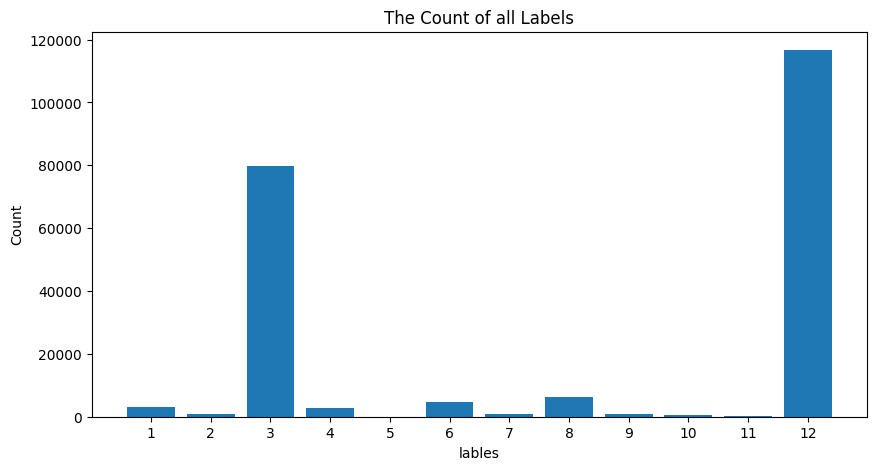

In [206]:
unique_values, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_values[1:], counts[1:])

plt.xticks(unique_values[1:])

# 그래프 제목과 축 레이블 설정
plt.title('The Count of all Labels')
plt.xlabel('lables')
plt.ylabel('Count')

# 그래프 출력
plt.show()

### Load Logs

In [207]:
with open("RNN_train_log.json", "r") as json_file:
    log_rnn = json.load(json_file)

with open("LSTM_train_log.json", "r") as json_file:
    log_lstm = json.load(json_file)

### Loss & Accuracy

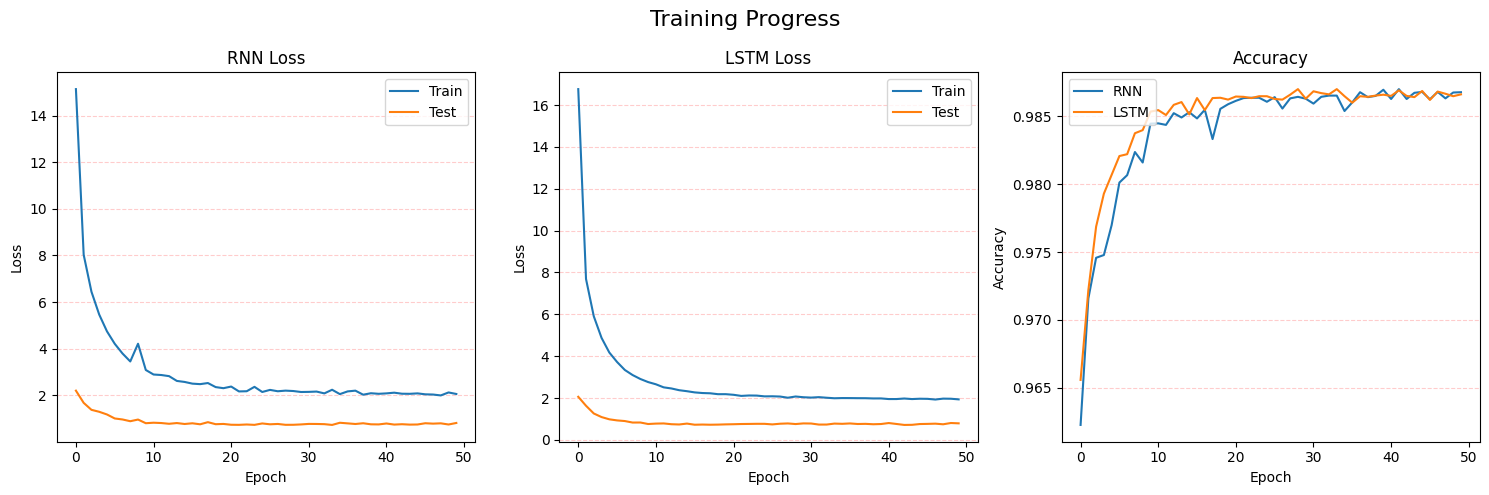

In [208]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Training Progress', fontsize=16)

line1, = ax[0].plot(log_rnn['TRAIN_LOSS'], label='Train')
line2, = ax[0].plot(log_rnn['TEST_LOSS'], label='Test')

ax[0].set_title('RNN Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

line3, = ax[1].plot(log_lstm['TRAIN_LOSS'], label='Train')
line4, = ax[1].plot(log_lstm['TEST_LOSS'], label='Test')
ax[1].set_title('LSTM Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')

line5, = ax[2].plot(log_rnn['ACCURACY'], label='RNN')
line6, = ax[2].plot(log_lstm['ACCURACY'], label='LSTM')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend(loc='upper left')

for axis in ax:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

### Evaluation Metrics

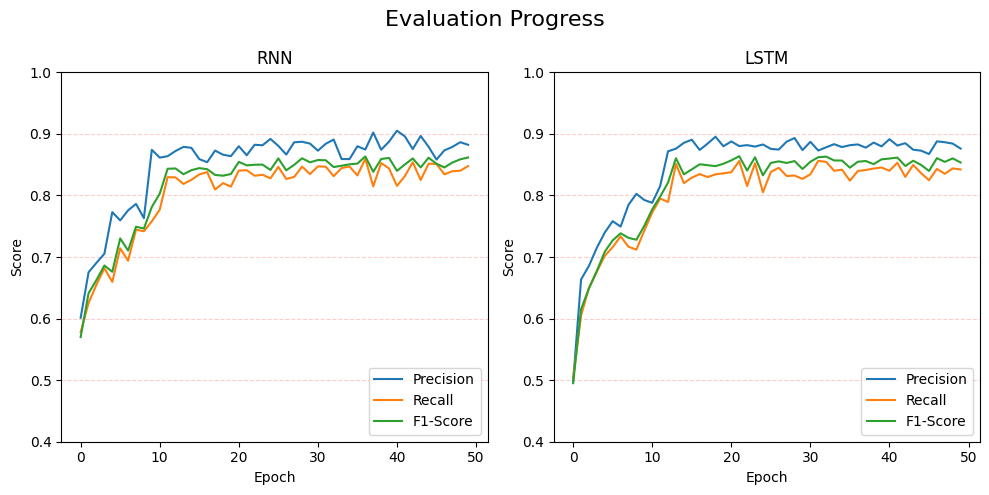

In [209]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Evaluation Progress', fontsize=16)

ax[0].plot(log_rnn['PRECISION'], label='Precision')
ax[0].plot(log_rnn['RECALL'], label='Recall')
ax[0].plot(log_rnn['F1'], label='F1-Score')
ax[0].set_title('RNN')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Score')
ax[0].legend(loc='lower right')
ax[0].set_ylim(0.4, 1)

ax[1].plot(log_lstm['PRECISION'], label='Precision')
ax[1].plot(log_lstm['RECALL'], label='Recall')
ax[1].plot(log_lstm['F1'], label='F1-Score')
ax[1].set_title('LSTM')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Score')
ax[1].legend(loc='lower right')
ax[1].set_ylim(0.4, 1)

for axis in ax:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

### Confusion Matrix

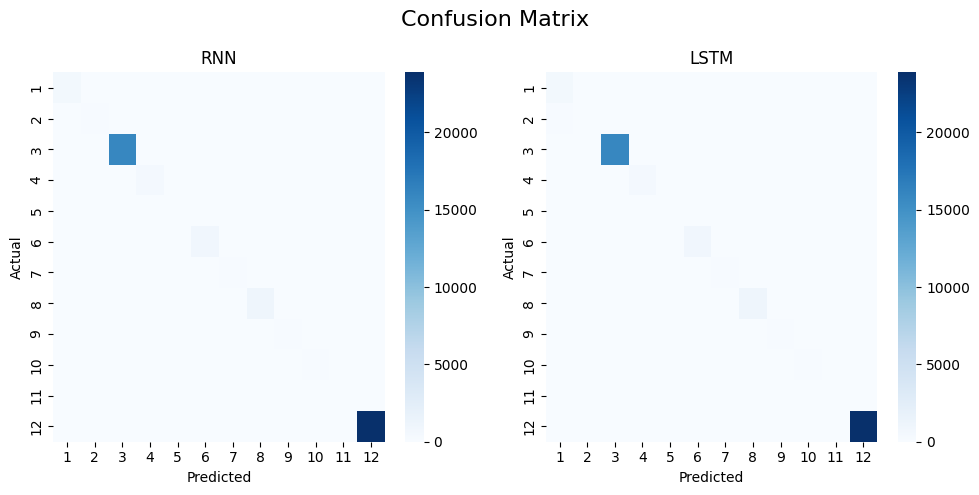

In [210]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 2개의 서브플롯 생성

fig.suptitle('Confusion Matrix', fontsize=16)

# RNN confusion matrix
matrix_rnn = np.array(log_rnn['CONFUSION_MATRIX'])[-1]
sns.heatmap(matrix_rnn, annot=False, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title(f'RNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# LSTM confusion matrix
matrix_lstm = np.array(log_lstm['CONFUSION_MATRIX'])[-1]
sns.heatmap(matrix_lstm, annot=False, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title(f'LSTM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# x축과 y축 ticks를 1부터 12로 설정
for ax in axes:
    ax.set_xticks(np.arange(12) + 0.5)  # 중간에 위치시키기 위해 0.5를 더함
    ax.set_xticklabels(np.arange(1, 13))  # 1부터 12까지의 레이블 설정
    ax.set_yticks(np.arange(12) + 0.5)
    ax.set_yticklabels(np.arange(1, 13))  # 1부터 12까지의 레이블 설정

plt.tight_layout()
plt.show()

#### Case per label

In [211]:
# RNN True Case와 False Case 저장
rnn_true = []
rnn_false = []

confusion_matrices_rnn = np.array(log_rnn['CONFUSION_MATRIX'])

for epoch in range(confusion_matrices_rnn.shape[0]):
    matrix = confusion_matrices_rnn[epoch]
    
    # True Case
    true_case = np.diag(matrix)
    
    # False Case
    false_case = matrix.sum(axis=1) - true_case
    
    rnn_true.append(true_case)
    rnn_false.append(false_case)

rnn_true = np.array(rnn_true)
rnn_false = np.array(rnn_false)

# LSTM True Case와 False Case 저장
lstm_true = []
lstm_false = []

confusion_matrices_lstm = np.array(log_lstm['CONFUSION_MATRIX'])

for epoch in range(confusion_matrices_lstm.shape[0]):
    matrix = confusion_matrices_lstm[epoch]
    
    # True Case
    true_case = np.diag(matrix)
    
    # False Case
    false_case = matrix.sum(axis=1) - true_case
    
    lstm_true.append(true_case)
    lstm_false.append(false_case)

lstm_true = np.array(lstm_true)
lstm_false = np.array(lstm_false)

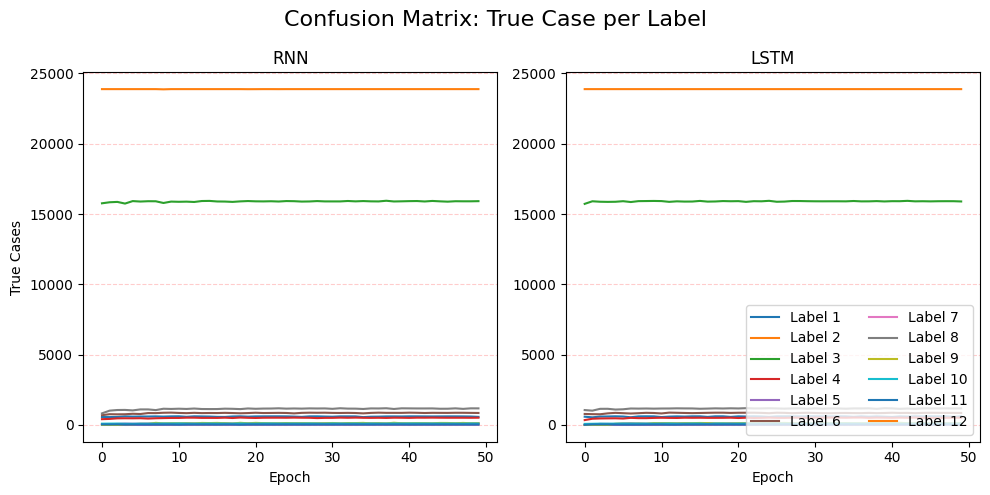

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Confusion Matrix: True Case per Label', fontsize=16)

# RNN
for label in range(rnn_true.shape[1]):
    axes[0].plot(rnn_true[:, label], label=f'Label {label+1}')

axes[0].set_title('RNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('True Cases')

# LSTM
for label in range(lstm_true.shape[1]):
    axes[1].plot(lstm_true[:, label], label=f'Label {label+1}')

axes[1].set_title('LSTM')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='lower right', ncol=2)

for axis in axes:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

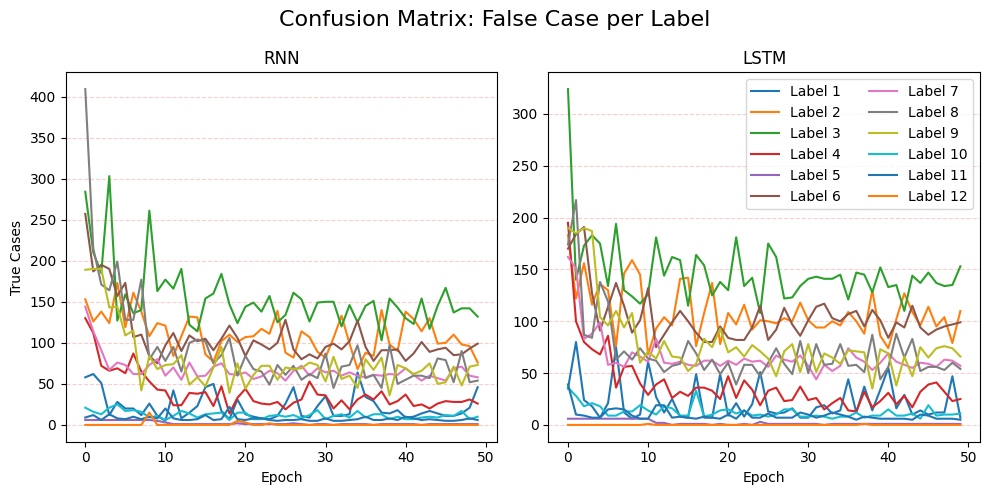

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Confusion Matrix: False Case per Label', fontsize=16)

# RNN
for label in range(rnn_false.shape[1]):
    axes[0].plot(rnn_false[:, label], label=f'Label {label+1}')

axes[0].set_title('RNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('True Cases')

# LSTM
for label in range(lstm_false.shape[1]):
    axes[1].plot(lstm_false[:, label], label=f'Label {label+1}')

axes[1].set_title('LSTM')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper right', ncol=2)

for axis in axes:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

#### Case ratio per label

In [214]:
# RNN True Case와 False Case 저장 (비율 계산)
rnn_true = []
rnn_false = []

confusion_matrices_rnn = np.array(log_rnn['CONFUSION_MATRIX'])

for epoch in range(confusion_matrices_rnn.shape[0]):
    matrix = confusion_matrices_rnn[epoch]
    
    # 레이블별 전체 데이터 수 (행의 합)
    total_case = matrix.sum(axis=1)
    
    # True Case: 대각선 값 / 전체 데이터 수
    true_case = np.diag(matrix) / total_case
    
    # False Case: (행의 합 - 대각선 값) / 전체 데이터 수
    false_case = (matrix.sum(axis=1) - np.diag(matrix)) / total_case
    
    rnn_true.append(true_case)
    rnn_false.append(false_case)

rnn_true = np.array(rnn_true)
rnn_false = np.array(rnn_false)

# LSTM True Case와 False Case 저장 (비율 계산)
lstm_true = []
lstm_false = []

confusion_matrices_lstm = np.array(log_lstm['CONFUSION_MATRIX'])

for epoch in range(confusion_matrices_lstm.shape[0]):
    matrix = confusion_matrices_lstm[epoch]
    
    # 레이블별 전체 데이터 수 (행의 합)
    total_case = matrix.sum(axis=1)
    
    # True Case: 대각선 값 / 전체 데이터 수
    true_case = np.diag(matrix) / total_case
    
    # False Case: (행의 합 - 대각선 값) / 전체 데이터 수
    false_case = (matrix.sum(axis=1) - np.diag(matrix)) / total_case
    
    lstm_true.append(true_case)
    lstm_false.append(false_case)

lstm_true = np.array(lstm_true)
lstm_false = np.array(lstm_false)

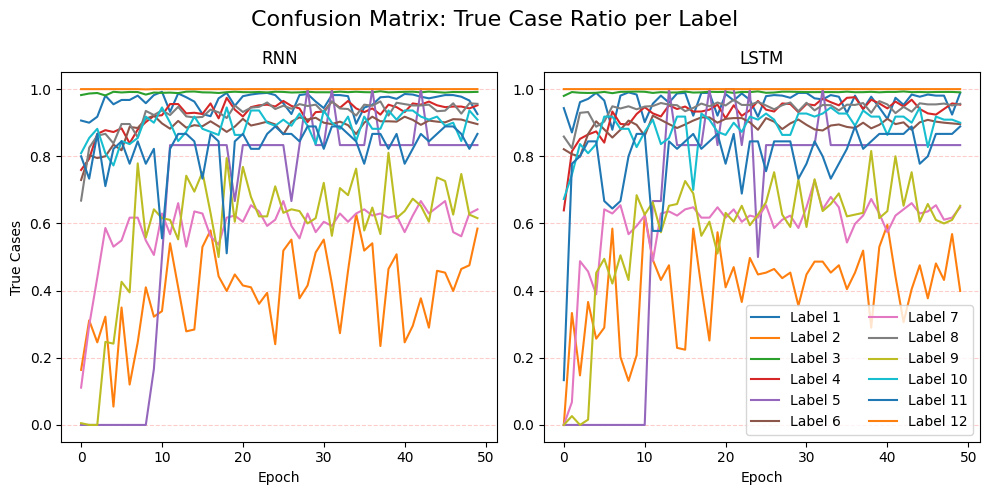

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Confusion Matrix: True Case Ratio per Label', fontsize=16)

# RNN
for label in range(rnn_true.shape[1]):
    axes[0].plot(rnn_true[:, label], label=f'Label {label+1}')

axes[0].set_title('RNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('True Cases')

# LSTM
for label in range(lstm_true.shape[1]):
    axes[1].plot(lstm_true[:, label], label=f'Label {label+1}')

axes[1].set_title('LSTM')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='lower right', ncol=2)

for axis in axes:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

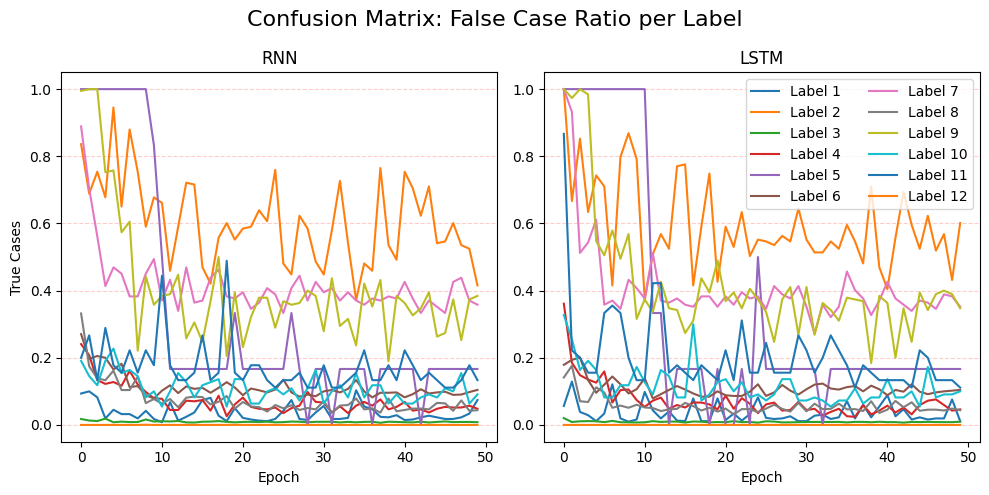

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Confusion Matrix: False Case Ratio per Label', fontsize=16)

# RNN
for label in range(rnn_false.shape[1]):
    axes[0].plot(rnn_false[:, label], label=f'Label {label+1}')

axes[0].set_title('RNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('True Cases')

# LSTM
for label in range(lstm_false.shape[1]):
    axes[1].plot(lstm_false[:, label], label=f'Label {label+1}')

axes[1].set_title('LSTM')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper right', ncol=2)

for axis in axes:
    axis.grid(True, axis='y', color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()